# Imports

In [63]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Normalization, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

In [26]:
df = pd.read_csv('Clean_Dataset.csv')

df = df.drop(['Unnamed: 0', 'flight'], axis=1)
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [68]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, predictions, alpha=0.2)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs. Predicted Prices")
    plt.grid(True)

    # Add the y=x line
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)

    plt.show()

# Data Manipulation

In [27]:
def convertStops(stops):
    if stops=='zero':
        return 0
    elif stops=='one':
        return 1
    else:
        return 2

In [28]:
df['stops_mapped'] = df['stops'].apply(convertStops)
df.drop('stops', axis=1, inplace=True)
df.sample(5)

,airline,source_city,departure_time,arrival_time,destination_city,class,duration,days_left,price,stops_mapped
246298,Vistara,Bangalore,Early_Morning,Afternoon,Delhi,Business,6.00,20,54841,1
95735,Indigo,Bangalore,Early_Morning,Afternoon,Mumbai,Economy,7.42,12,6548,1
206786,Vistara,Delhi,Evening,Afternoon,Mumbai,Business,19.50,2,79977,1
282617,Vistara,Hyderabad,Night,Night,Bangalore,Business,23.33,43,41974,1
105853,GO_FIRST,Bangalore,Early_Morning,Afternoon,Kolkata,Economy,5.00,24,4162,1


In [29]:
df['stops_mapped'].corr(df['price'])

np.float64(0.1196484707241398)

In [30]:
df.groupby('airline')['price'].mean()

airline
AirAsia       4091.072742
Air_India    23507.019112
GO_FIRST      5652.007595
Indigo        5324.216303
SpiceJet      6179.278881
Vistara      30396.536302
Name: price, dtype: float64

In [31]:
airline_map = {'AirAsia':0, 'Indigo':1, 'GO_FIRST':2, 'SpiceJet':3, 'Air_India':4, 'Vistara':5}
df['airline_mapped'] = df['airline'].map(airline_map)
df.drop('airline', axis=1, inplace=True)
df.sample(5)

,source_city,departure_time,arrival_time,destination_city,class,duration,days_left,price,stops_mapped,airline_mapped
142218,Kolkata,Morning,Morning,Bangalore,Economy,2.50,48,3862,0,1
28474,Delhi,Early_Morning,Early_Morning,Kolkata,Economy,2.08,48,3999,0,2
152133,Kolkata,Morning,Night,Chennai,Economy,13.17,44,5390,1,4
213864,Delhi,Evening,Morning,Bangalore,Business,16.17,25,42457,1,4
129283,Kolkata,Early_Morning,Evening,Mumbai,Economy,10.58,14,7958,1,2


In [32]:
df['route'] = df['source_city'] + '-' + df['destination_city']
df.groupby('route')['price'].mean()

route
Bangalore-Chennai      23321.850078
Bangalore-Delhi        17723.313972
Bangalore-Hyderabad    21226.121192
Bangalore-Kolkata      23500.061229
Bangalore-Mumbai       23128.618672
Chennai-Bangalore      25081.850454
Chennai-Delhi          18981.863948
Chennai-Hyderabad      21591.345404
Chennai-Kolkata        22669.932407
Chennai-Mumbai         22765.849647
Delhi-Bangalore        17880.216315
Delhi-Chennai          19369.881354
Delhi-Hyderabad        17347.288379
Delhi-Kolkata          20566.409418
Delhi-Mumbai           19355.829812
Hyderabad-Bangalore    21347.177998
Hyderabad-Chennai      21848.065989
Hyderabad-Delhi        17243.945685
Hyderabad-Kolkata      20823.893201
Hyderabad-Mumbai       20080.865759
Kolkata-Bangalore      22744.808428
Kolkata-Chennai        23660.361040
Kolkata-Delhi          19422.354559
Kolkata-Hyderabad      21500.011397
Kolkata-Mumbai         22078.883579
Mumbai-Bangalore       23147.873807
Mumbai-Chennai         22781.899112
Mumbai-Delhi          

In [33]:
# Calculate the mean price for each route
mean_price_by_route = df.groupby('route')['price'].mean()

# Sort the routes by their mean price
ranked_routes = mean_price_by_route.sort_values(ascending=True)

# Create a dictionary mapping each route to its rank (0-based)
route_rank_dict = {route: rank for rank, route in enumerate(ranked_routes.index)}

# Display the dictionary
print(route_rank_dict)

{'Hyderabad-Delhi': 0, 'Delhi-Hyderabad': 1, 'Bangalore-Delhi': 2, 'Delhi-Bangalore': 3, 'Mumbai-Delhi': 4, 'Chennai-Delhi': 5, 'Delhi-Mumbai': 6, 'Delhi-Chennai': 7, 'Kolkata-Delhi': 8, 'Hyderabad-Mumbai': 9, 'Delhi-Kolkata': 10, 'Hyderabad-Kolkata': 11, 'Mumbai-Hyderabad': 12, 'Bangalore-Hyderabad': 13, 'Hyderabad-Bangalore': 14, 'Kolkata-Hyderabad': 15, 'Chennai-Hyderabad': 16, 'Hyderabad-Chennai': 17, 'Kolkata-Mumbai': 18, 'Mumbai-Kolkata': 19, 'Chennai-Kolkata': 20, 'Kolkata-Bangalore': 21, 'Chennai-Mumbai': 22, 'Mumbai-Chennai': 23, 'Bangalore-Mumbai': 24, 'Mumbai-Bangalore': 25, 'Bangalore-Chennai': 26, 'Bangalore-Kolkata': 27, 'Kolkata-Chennai': 28, 'Chennai-Bangalore': 29}


In [34]:
df['route_mapped'] = df['route'].map(route_rank_dict)
df.drop(['route', 'source_city', 'destination_city'], axis=1, inplace=True)
df.sample(5)

,departure_time,arrival_time,class,duration,days_left,price,stops_mapped,airline_mapped,route_mapped
143803,Afternoon,Night,Economy,5.92,14,6594,1,3,15
129134,Morning,Evening,Economy,4.67,13,7959,1,1,18
280799,Afternoon,Night,Business,8.00,12,38099,1,5,14
196239,Early_Morning,Evening,Economy,10.75,32,4755,1,5,29
15530,Evening,Night,Economy,7.00,28,7409,1,2,3


In [35]:
df['route_mapped'].corr(df['price'])

np.float64(0.08943922270058315)

In [36]:
class_map = {'Economy':0, 'Business':1}
df['class_mapped'] = df['class'].map(class_map)
df.drop('class', axis=1, inplace=True)
df.sample(5)

,departure_time,arrival_time,duration,days_left,price,stops_mapped,airline_mapped,route_mapped,class_mapped
174934,Evening,Morning,14.92,38,6275,1,5,11,0
105386,Late_Night,Early_Morning,6.75,21,3393,1,0,27,0
139209,Night,Evening,20.58,27,8111,1,5,21,0
59537,Afternoon,Evening,1.75,39,2074,0,5,25,0
63611,Afternoon,Afternoon,25.33,14,7412,1,3,19,0


In [37]:
df['class_mapped'].corr(df['price'])

np.float64(0.9378603239059123)

In [38]:
df.departure_time.unique()

array(['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [39]:
df.groupby('departure_time')['price'].mean()

departure_time
Afternoon        18179.203331
Early_Morning    20370.676718
Evening          21232.361894
Late_Night        9295.299387
Morning          21630.760254
Night            23062.146808
Name: price, dtype: float64

In [40]:
# Calculate the mean price for each departure time
mean_price_by_departure_time = df.groupby('departure_time')['price'].mean()

# Sort the departure times by their mean price
ranked_departure_times = mean_price_by_departure_time.sort_values(ascending=True)

# Create a mapping where values are scaled between 0 and 1
min_price = ranked_departure_times.min()
max_price = ranked_departure_times.max()

# Avoid division by zero if min_price and max_price are the same
if max_price == min_price:
    scaled_departure_time_map = {time: 0.5 for time in ranked_departure_times.index}
else:
    scaled_departure_time_map = {time: (price - min_price) / (max_price - min_price) for time, price in ranked_departure_times.items()}

# Map the original 'departure_time' column to these scaled values
df['departure_time_scaled'] = df['departure_time'].map(scaled_departure_time_map)
df.drop('departure_time', axis=1, inplace=True)

df.sample(5)

,arrival_time,duration,days_left,price,stops_mapped,airline_mapped,route_mapped,class_mapped,departure_time_scaled
296113,Evening,12.67,6,67137,1,5,20,1,0.804496
175532,Night,11.00,43,4368,1,4,11,0,0.896027
148057,Late_Night,10.50,1,7954,1,1,28,0,0.645311
261244,Morning,14.42,49,44280,1,5,26,1,0.867088
148942,Night,5.50,12,13014,1,5,28,0,0.867088


In [41]:
df['departure_time_scaled'].corr(df['price'])

np.float64(0.07273217711497877)

In [42]:
df.groupby('arrival_time')['price'].mean()

arrival_time
Afternoon        18494.598993
Early_Morning    14993.139521
Evening          23044.371615
Late_Night       11284.906078
Morning          22231.076098
Night            21586.758341
Name: price, dtype: float64

In [43]:
# Calculate the mean price for each arrival time
mean_price_by_arrival_time = df.groupby('arrival_time')['price'].mean()

# Sort the arrival times by their mean price
ranked_arrival_times = mean_price_by_arrival_time.sort_values(ascending=True)

# Create a mapping where values are scaled between 0 and 1
min_price_arrival = ranked_arrival_times.min()
max_price_arrival = ranked_arrival_times.max()

# Avoid division by zero if min_price and max_price are the same
if max_price_arrival == min_price_arrival:
    scaled_arrival_time_map = {time: 0.5 for time in ranked_arrival_times.index}
else:
    scaled_arrival_time_map = {time: (price - min_price_arrival) / (max_price_arrival - min_price_arrival) for time, price in ranked_arrival_times.items()}

# Map the original 'arrival_time' column to these scaled values
df['arrival_time_scaled'] = df['arrival_time'].map(scaled_arrival_time_map)
df.drop('arrival_time', axis=1, inplace=True)

# Display the first few rows with the new scaled column
df.sample(5)

,duration,days_left,price,stops_mapped,airline_mapped,route_mapped,class_mapped,departure_time_scaled,arrival_time_scaled
49434,11.83,33,6219,1,4,4,0,0.804496,1.000000
106587,2.58,29,3393,0,4,27,0,0.000000,0.315340
87609,7.08,19,6022,1,2,2,0,0.645311,0.876048
30630,9.50,17,3989,1,2,1,0,0.804496,0.613097
189563,10.83,18,4413,1,5,22,0,1.000000,0.315340


In [44]:
df['arrival_time_scaled'].corr(df['price'])

np.float64(0.1288531773387412)

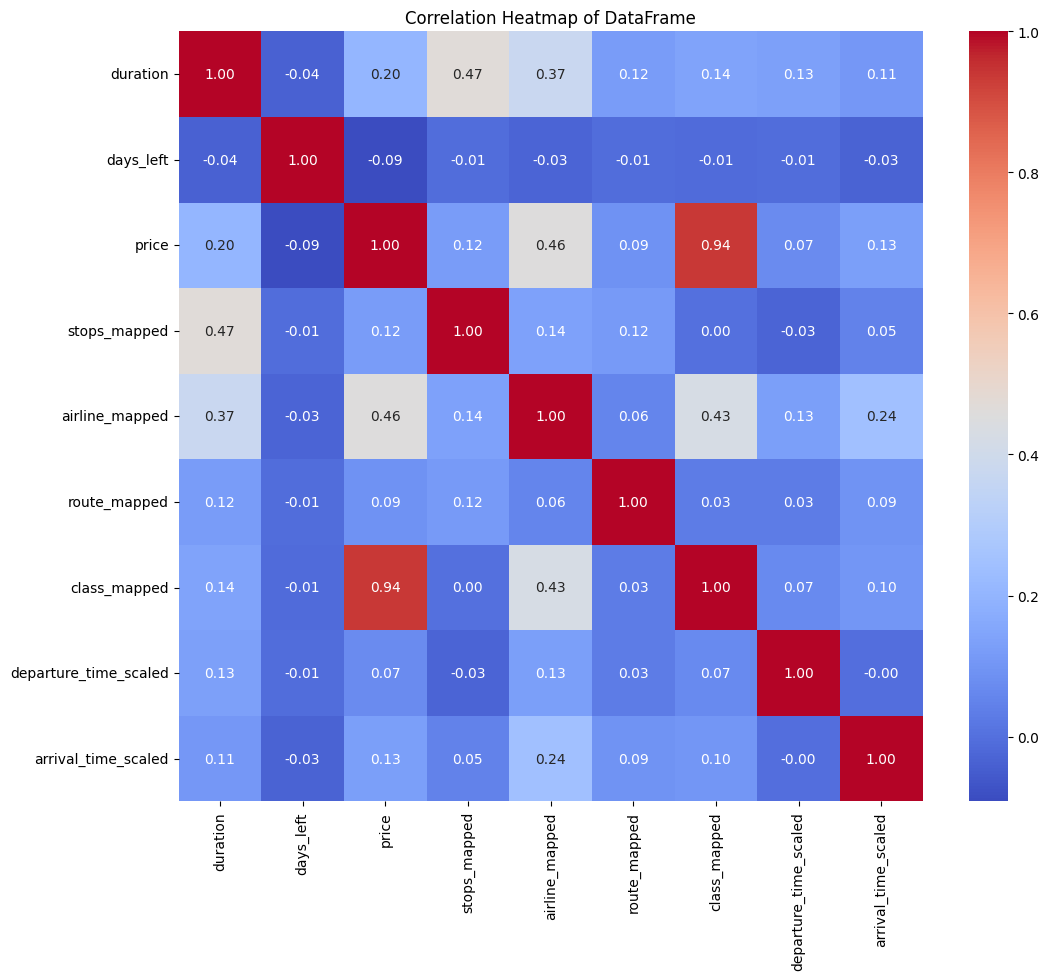

In [45]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of DataFrame')
plt.show()

In [46]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [47]:
x_train = train_df.drop('price', axis=1).values
y_train = train_df['price'].values

x_test = test_df.drop('price', axis=1).values
y_test = test_df['price'].values

In [48]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Model Training

In [59]:
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(x_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished


RandomForestRegressor(max_depth=25, min_samples_split=4, n_estimators=500,
                      n_jobs=-1, random_state=42, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.9s finished


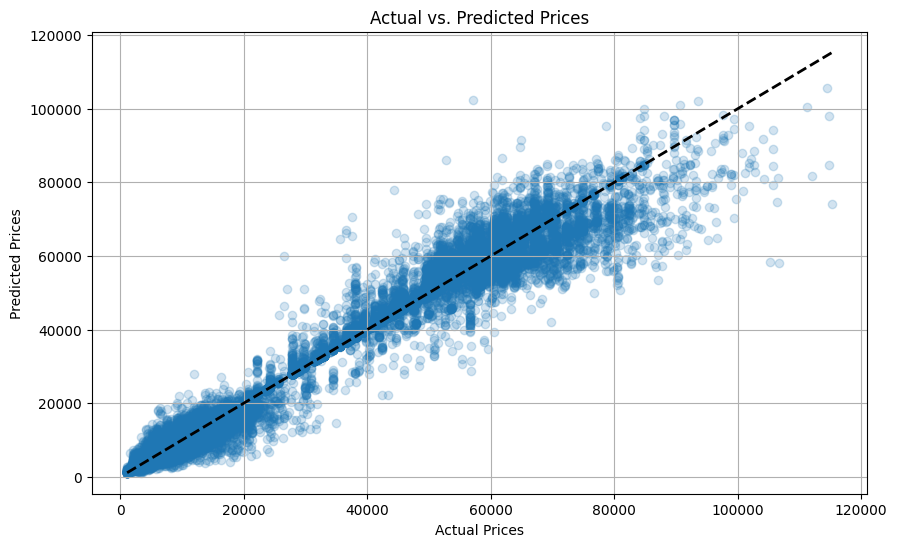

In [72]:
rf_predictions = rf_model.predict(x_test_scaled)

plot_predictions(y_test, rf_predictions)

In [61]:
r2_score(y_test, predictions)

0.9854068676654707

In [62]:
mean_absolute_error(y_test, predictions)

np.float64(1122.9828843711095)

In [83]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=25,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # Stop if validation score doesn't improve
)

xgb_model.fit(x_train_scaled, y_train, eval_set=[(x_test_scaled, y_test)], verbose=True)

[0]	validation_0-rmse:21602.41392
[1]	validation_0-rmse:20556.84997
[2]	validation_0-rmse:19564.51679
[3]	validation_0-rmse:18622.87275
[4]	validation_0-rmse:17728.91582
[5]	validation_0-rmse:16880.74021
[6]	validation_0-rmse:16075.64795
[7]	validation_0-rmse:15311.44061
[8]	validation_0-rmse:14586.18546
[9]	validation_0-rmse:13897.32945
[10]	validation_0-rmse:13244.59340
[11]	validation_0-rmse:12625.67893
[12]	validation_0-rmse:12039.26326
[13]	validation_0-rmse:11482.41786
[14]	validation_0-rmse:10954.21571
[15]	validation_0-rmse:10453.88681
[16]	validation_0-rmse:9979.99559
[17]	validation_0-rmse:9530.50121
[18]	validation_0-rmse:9106.40149
[19]	validation_0-rmse:8704.63510
[20]	validation_0-rmse:8324.51841
[21]	validation_0-rmse:7965.08096
[22]	validation_0-rmse:7625.63104
[23]	validation_0-rmse:7304.94021
[24]	validation_0-rmse:7002.50759
[25]	validation_0-rmse:6717.13366
[26]	validation_0-rmse:6448.45360
[27]	validation_0-rmse:6195.36522
[28]	validation_0-rmse:5955.11356
[29]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=25,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

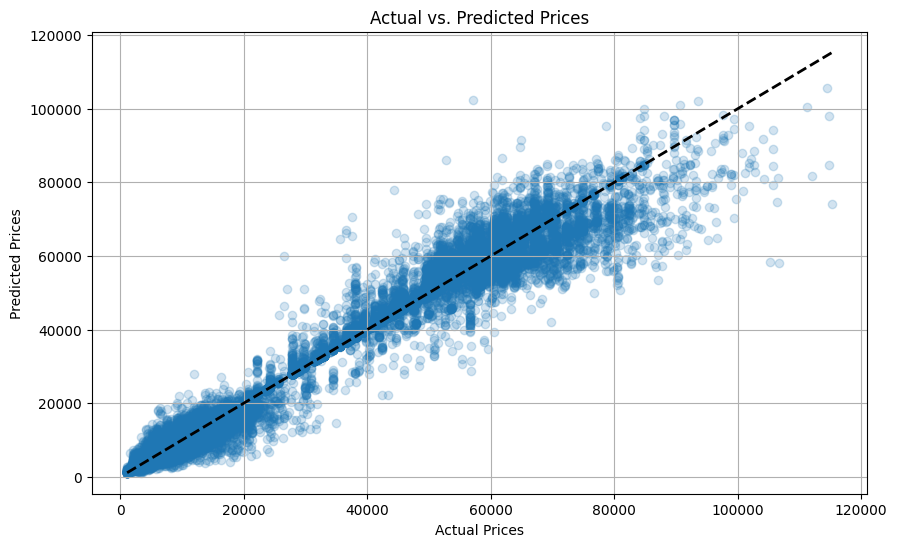

In [84]:
xgb_predictions = xgb_model.predict(x_test_scaled)

plot_predictions(y_test, xgb_predictions)

In [85]:
mean_absolute_error(y_test, xgb_predictions)

np.float64(1205.3962186939905)

In [86]:
r2_score(y_test, xgb_predictions)

0.9848850965499878

In [87]:
ensemble_predictions = (rf_predictions + xgb_predictions) / 2
mean_absolute_error(y_test, ensemble_predictions)

np.float64(1127.4580133751972)

In [88]:
r2_score(y_test, ensemble_predictions)

0.9859740132031173